In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u"]#,"g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

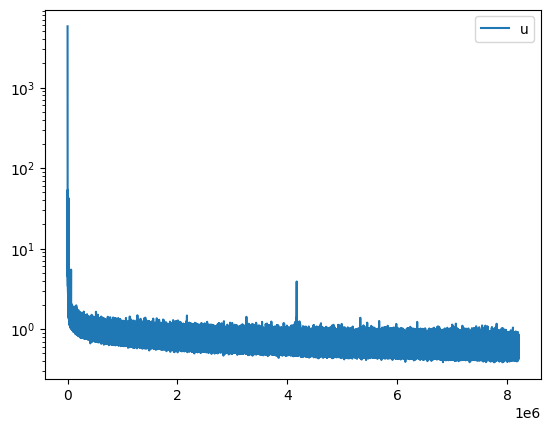

In [3]:
i = 0
for x in loss_bands:
    plt.plot(x, label=bands[i])
    i+=1

plt.yscale("log")
plt.legend()

0.6681890487670898


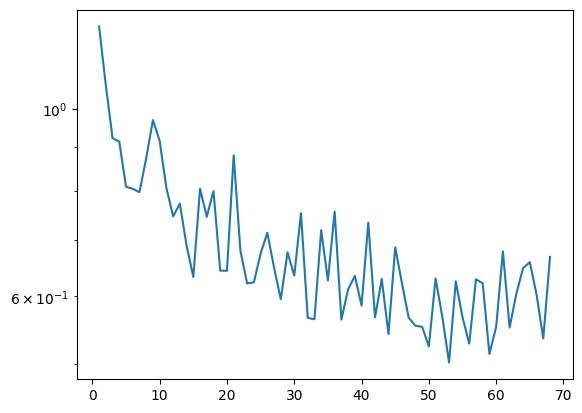

In [4]:
i = 0
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [6]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

def cut(z):
    return 10**(z+4)

band = 0

z = sps_params_train[:, 0]
mass = sps_params_train[:, -1]
mag = phot_train[:, band]

inds = np.where(mass > cut(z))[0]

sps_params_train = sps_params_train[inds]
phot_train = phot_train[inds]


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


971681
total outliers:  56.9957630127583


(1e-32, 1e-23)

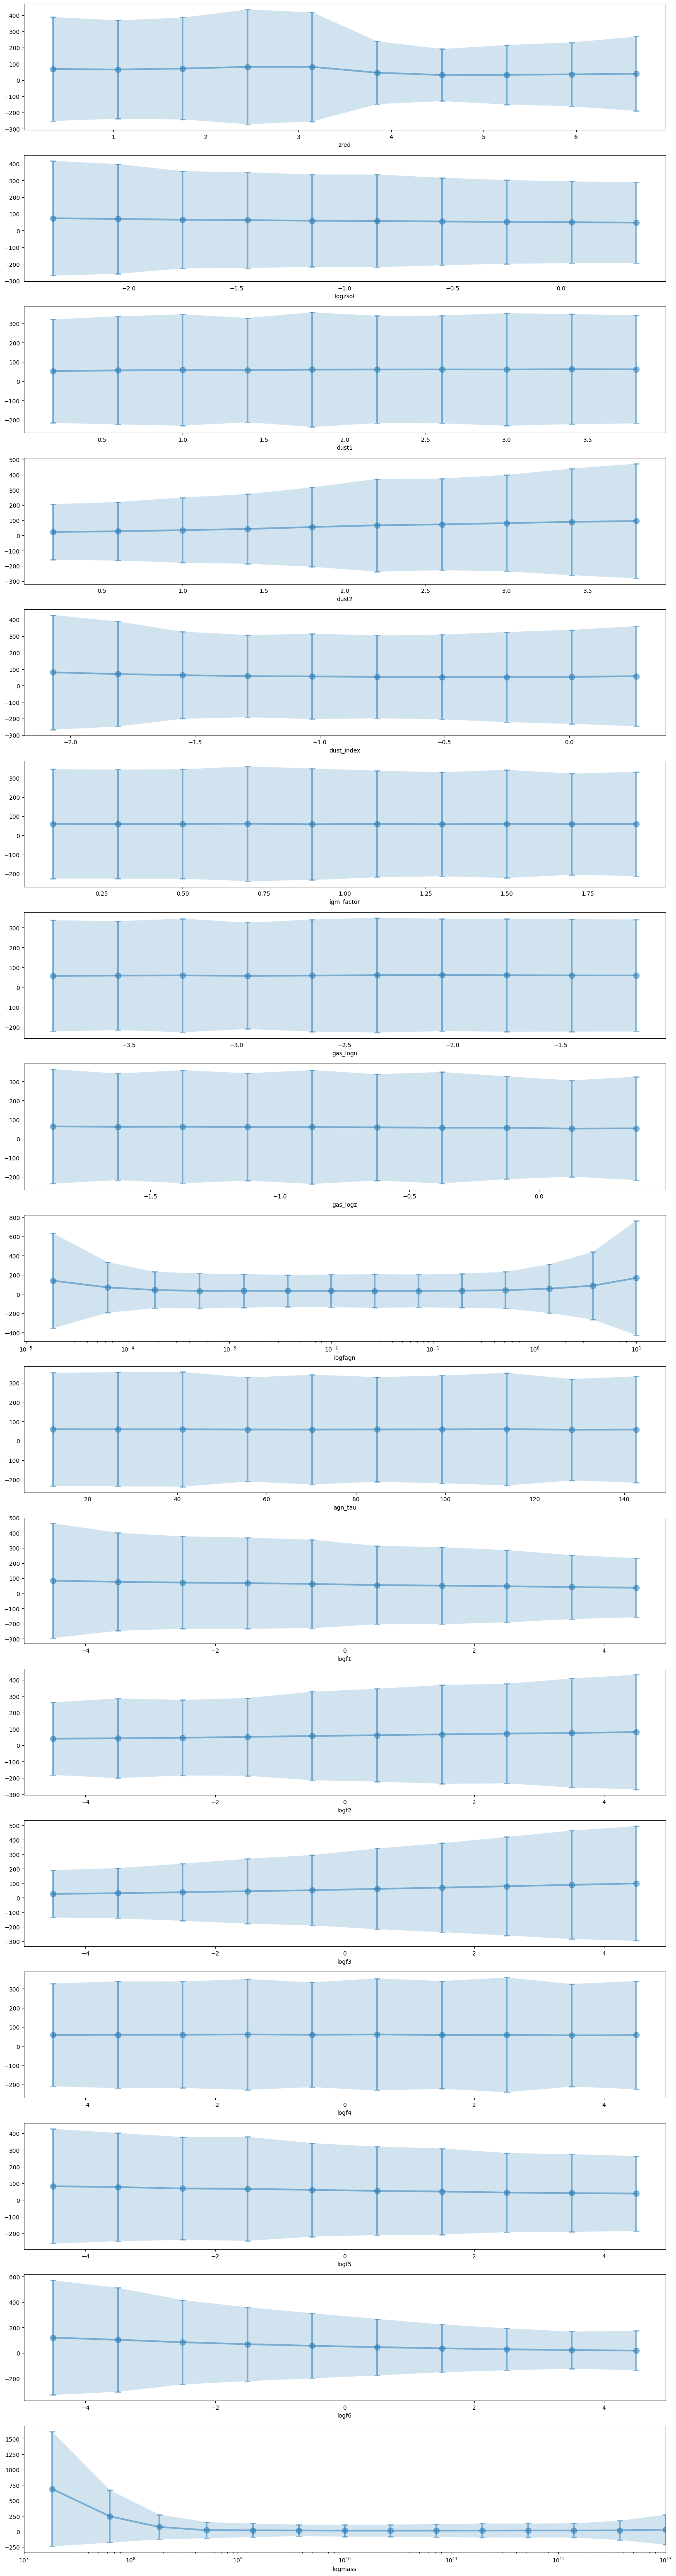

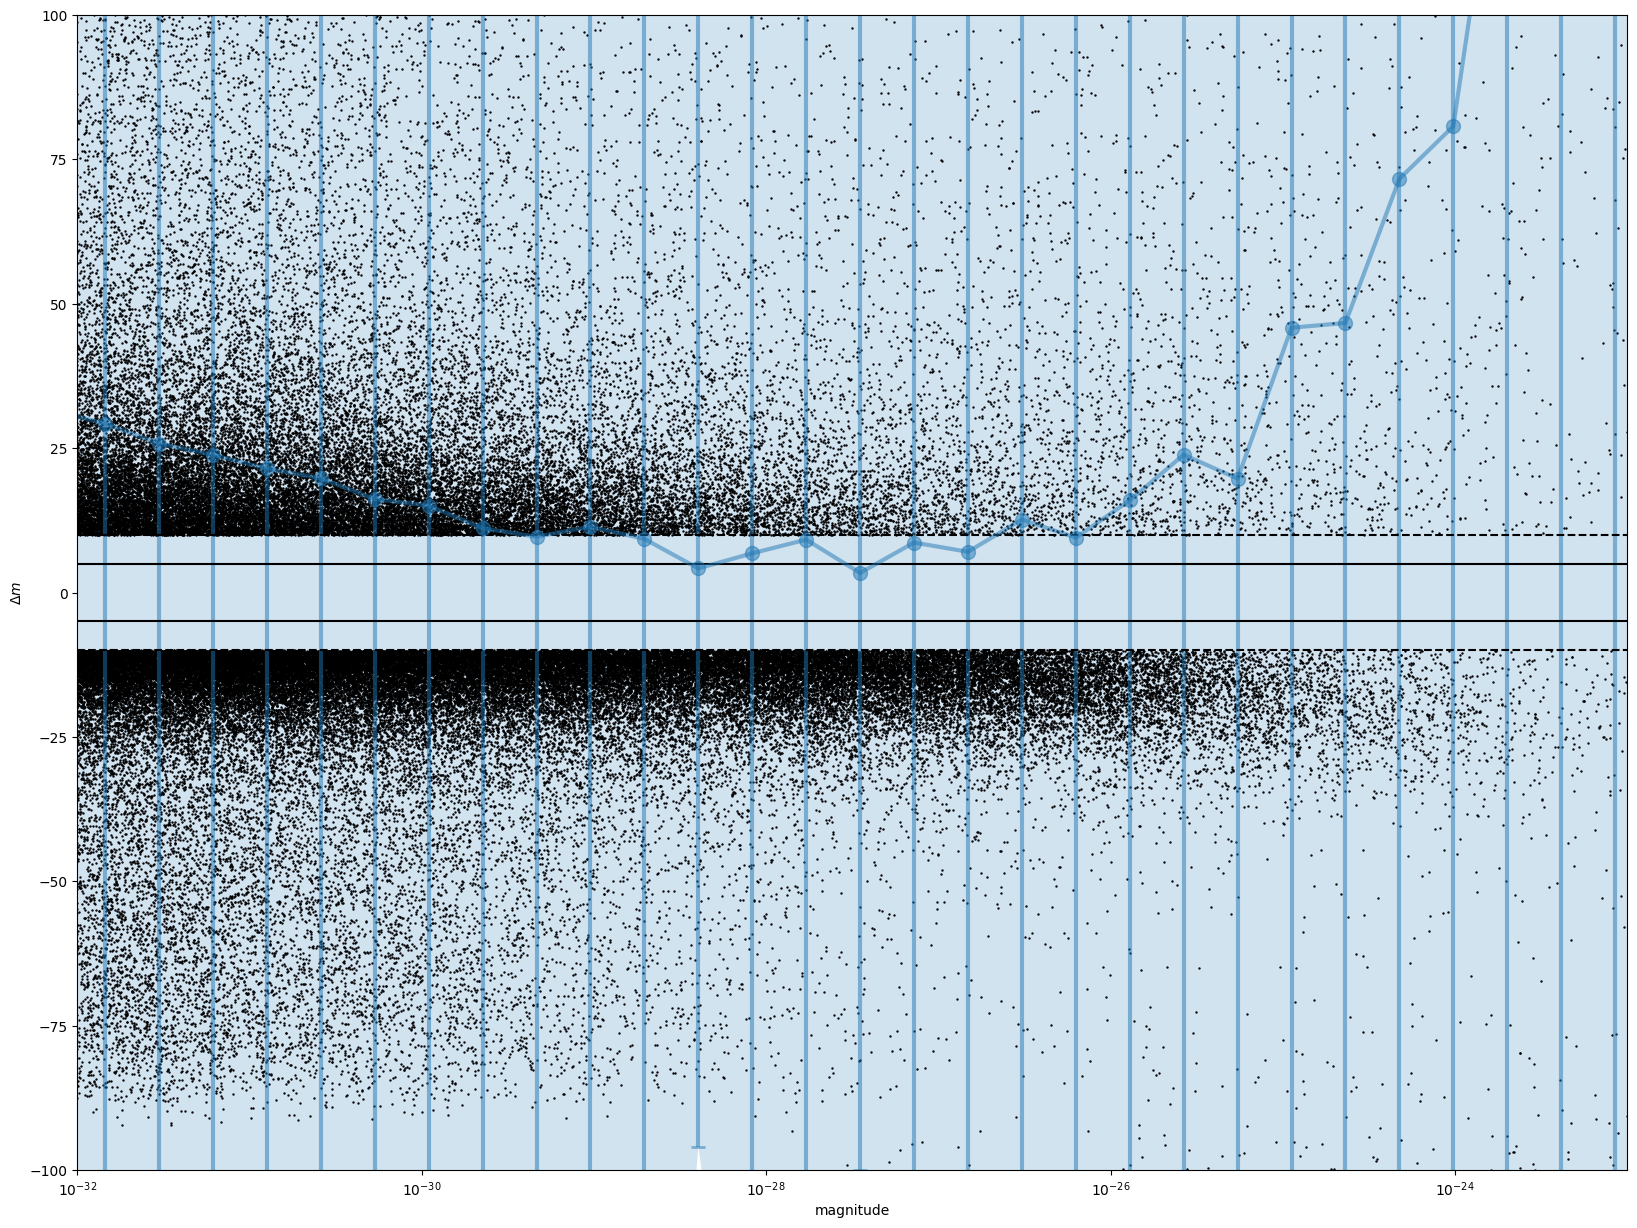

In [7]:
def mab_to_flux(mag):
    return 3.631e-20*10**(-(mag/2.5))


#mag_cut_upper = 30
#mag_cut_lower = 10
#inds = np.where((phot_train[:, 0] < mag_cut_upper) & (phot_train[:, 0] > mag_cut_lower))[0] #UBAND ONLY!!!!!!!!!!!!!!!!!!!!!!

#phot_train = phot_train[inds]
#sps_params_train = sps_params_train[inds, :]

nsamples=1200000
band = 0
#z_train = sps_params_train[:nsamples, 0]
#mass_train = sps_params_train[:nsamples, -1]
#mag = phot_train[:nsamples, band]

#inds = np.where(mass_train > cut(z_train))[0]

#sps_params_train = sps_params_train[inds]
#phot_train = phot_train[inds]

y_bound = 10.0
sps_params = sps_params_train[:nsamples, :]
m_mimic = mab_to_flux(model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0]))
print(sps_params.shape[0])
m_true = mab_to_flux(phot_train[:nsamples, :])
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = ((m_mimic[:, j]-m_true[:, j])/(m_true[:, j]))*100
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', np.logspace(-50, -19, 100))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', np.logspace(-50, -19, 100))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')
axes2.set_xscale('log')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

axes2.axhline(y=y_bound/2, color='k', linestyle='-')
axes2.axhline(y=-y_bound/2, color='k', linestyle='-')

#axes2.axhline(y=1, color='k', linestyle='-')
#axes2.axhline(y=-1, color='k', linestyle='-')

#axes2.axvline(x=10, color='k', linestyle='--')
#axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-100, 100)

axes2.set_xlim(1e-32, 1e-23)


In [8]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

def cut(z):
    return 10**(z+4)

band = 0

z = sps_params_train[:, 0]
mass = sps_params_train[:, -1]
mag = phot_train[:, band]

inds = np.where(mass > cut(z))[0]

sps_params_train = sps_params_train[inds]
phot_train = phot_train[inds]

total outliers:  18.618147313778906


(-10.0, 4.0)

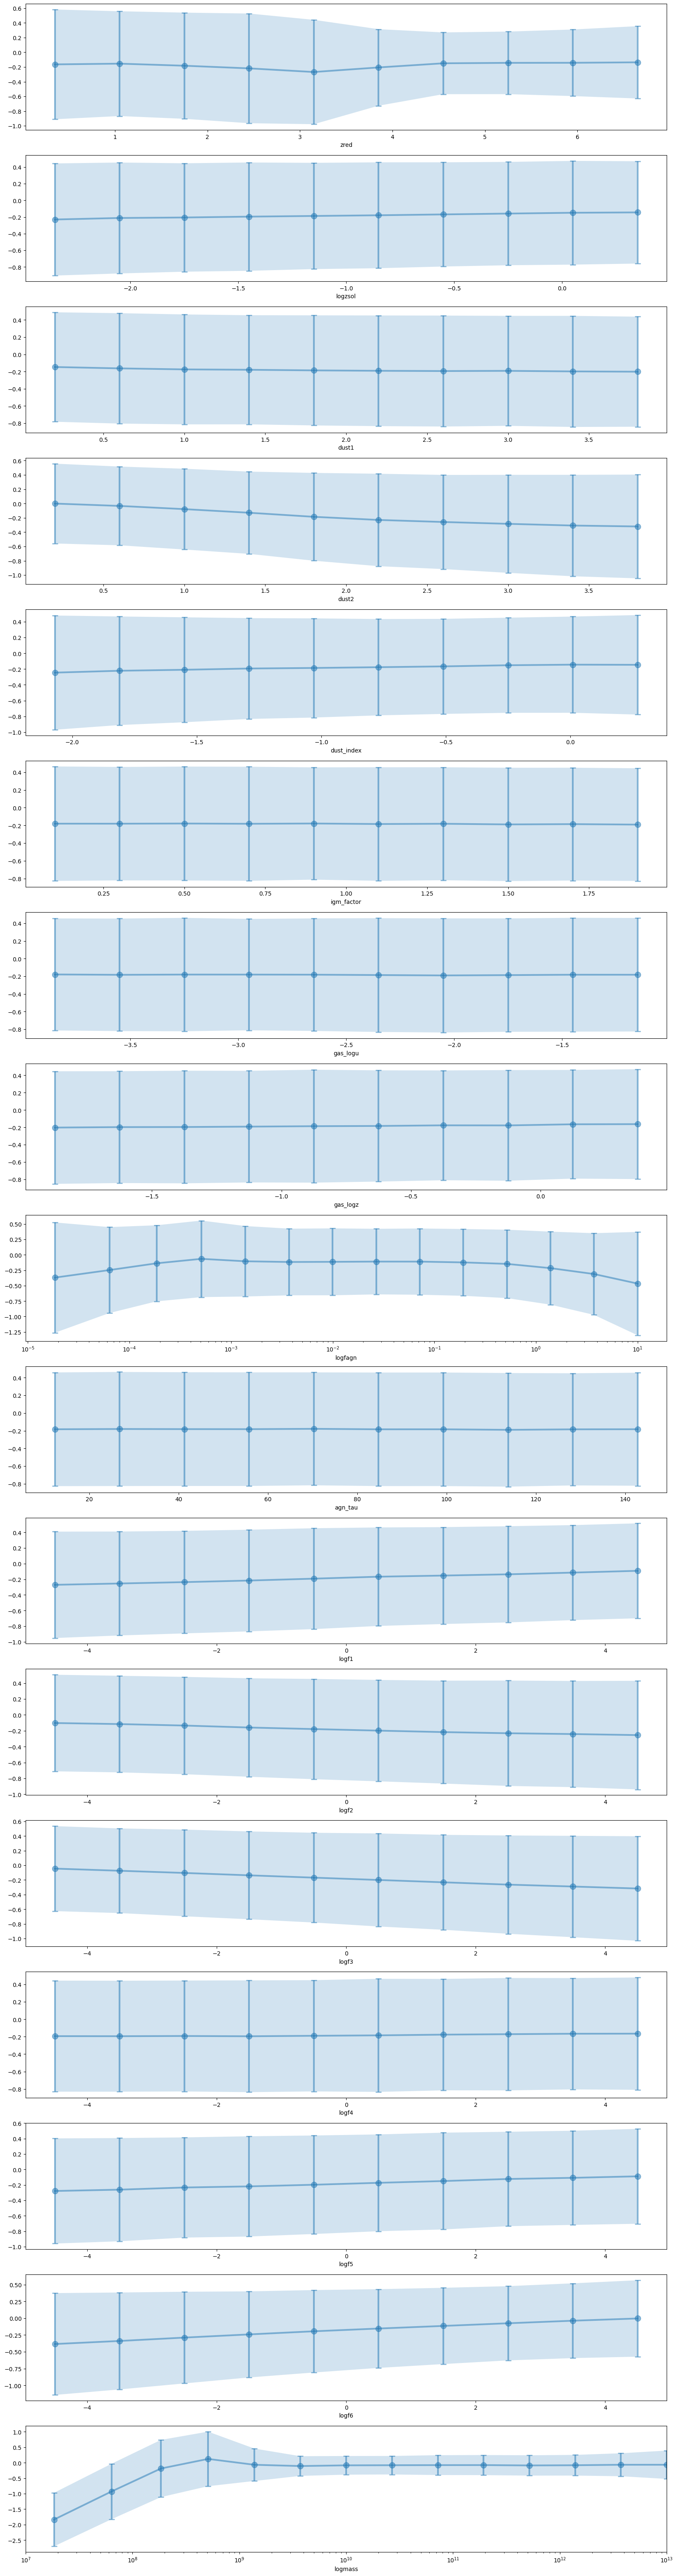

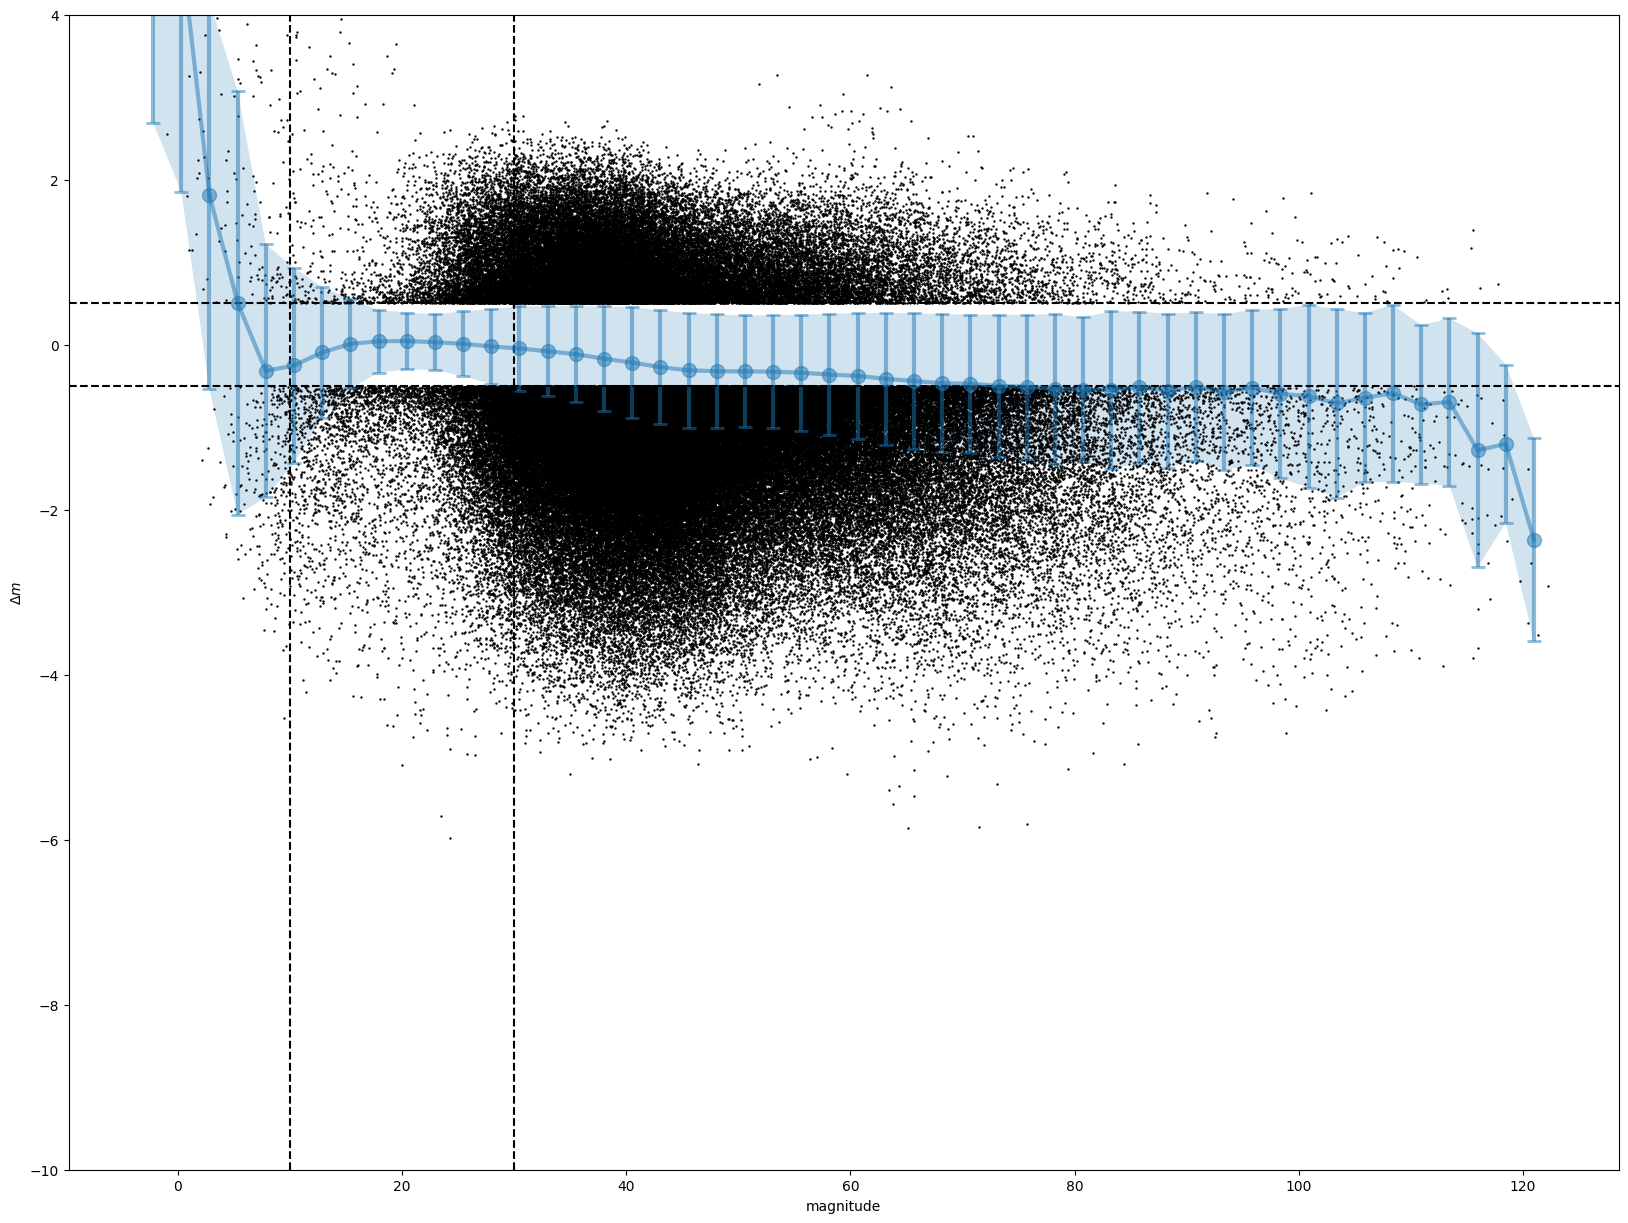

In [9]:
nsamples=1200000
y_bound = 0.5
sps_params = sps_params_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0])
m_true = phot_train[:nsamples, :]
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = m_mimic[:, j]-m_true[:, j]
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', 50)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', 50)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

#axes2.axhline(y=0.1, color='k', linestyle='-')
#axes2.axhline(y=0.1, color='k', linestyle='-')

axes2.axvline(x=10, color='k', linestyle='--')
axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-10, 4)

#axes2.set_xlim(0, 40)


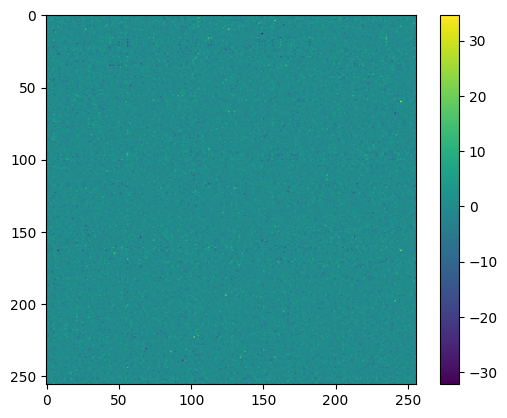

In [10]:
weights = model._models[0].W
biases = model._models[0].b
a = model._models[0].alphas
b = model._models[0].betas

layer = 3

weights[layer].shape

plt.imshow(np.transpose(weights[layer]))
plt.colorbar()

(array([ 1.,  0., 56.,  5.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.06852124, -0.04336745, -0.01821367,  0.00694011,  0.0320939 ,
         0.05724768,  0.08240147,  0.10755525,  0.13270904,  0.15786283,
         0.1830166 ,  0.20817038,  0.23332417,  0.25847796,  0.28363174,
         0.30878553,  0.33393931,  0.3590931 ,  0.38424689,  0.40940067,
         0.43455446,  0.45970824,  0.48486203,  0.51001579,  0.5351696 ,
         0.56032336,  0.58547717,  0.61063093,  0.63578475,  0.6609385 ,
         0.68609232,  0.71124607,  0.73639983,  0.76155365,  0.7867074 ,
         0.81186122,  0.83701497,  0.86216879,  0.88732255,  0.91247636,
         0.93763012,  0.96278393,  0.98793769,  1.01309144,  1.03824532,
         1.06339908,  1.08855283,  1.11370659,  1.13886046,

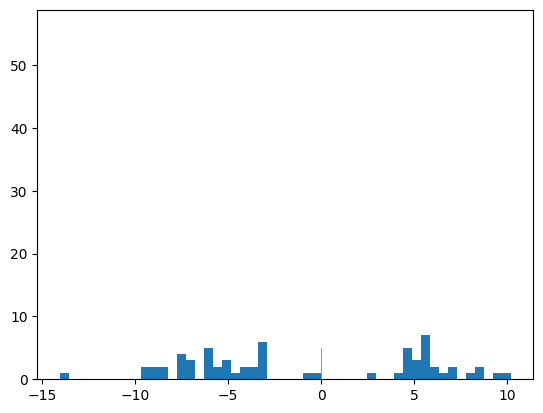

In [11]:
layer = 5

plt.hist(a[layer].numpy(), bins=50)
plt.hist(b[layer].numpy(), bins=50)

#plt.hist(a[layer])

(array([2., 0., 1., 2., 2., 1., 0., 1., 0., 2., 1., 1., 2., 4., 0., 3., 3.,
        1., 2., 2., 0., 2., 3., 0., 2., 2., 0., 0., 0., 2., 2., 2., 2., 0.,
        1., 1., 4., 2., 1., 0., 2., 1., 1., 1., 0., 0., 0., 2., 0., 1.]),
 array([-13.49682999, -12.84980774, -12.20278549, -11.5557642 ,
        -10.90874195, -10.2617197 ,  -9.61469746,  -8.96767521,
         -8.32065392,  -7.67363167,  -7.02660942,  -6.37958717,
         -5.7325654 ,  -5.08554316,  -4.43852139,  -3.79149914,
         -3.14447713,  -2.49745512,  -1.85043299,  -1.20341086,
         -0.55638885,   0.0906332 ,   0.73765528,   1.38467729,
          2.03169942,   2.67872143,   3.32574344,   3.97276545,
          4.61978769,   5.26680946,   5.91383171,   6.56085396,
          7.20787573,   7.85489798,   8.50191975,   9.14894199,
          9.79596424,  10.44298649,  11.09000778,  11.73703003,
         12.38405228,  13.03107452,  13.67809677,  14.32511806,
         14.97214031,  15.61916256,  16.26618385,  16.9132061 ,
      

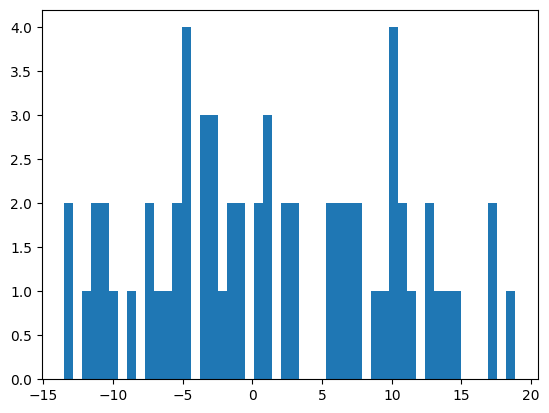

In [12]:
layer = 5

biases[layer].shape
plt.hist(biases[layer].numpy(), bins=50)